In [1]:

import numpy as np
import sys
import os
import pandas as pd
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
from sklearn.decomposition import PCA, IncrementalPCA
from scipy import stats
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
cmap = 'husl'

In [3]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [4]:
results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
#results_dir = os.path.join('../../data/', 'results')

In [5]:
analysis_name = 'corrs_ordered_up_for_PCA'

In [6]:
data_dir = os.path.join(results_dir, analysis_name, 'corrs_results')

In [7]:
data_dir

'/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/corrs_ordered_up_for_PCA/corrs_results'

In [8]:
corrsdir = os.path.join(results_dir, analysis_name)

In [9]:
param_corrs = glob.glob(os.path.join(corrsdir, 'isfc_*'))

In [10]:
param_corrs

['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/corrs_ordered_up_for_PCA/isfc_eigenvector_centrality_laplace_50',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/corrs_ordered_up_for_PCA/isfc_PCA_laplace_50']

In [11]:
levels = np.arange(0,4,1)
conditions = ['intact', 'paragraph', 'rest', 'word']
Reduction_type = ['PCA', 'eigenvector_centrality']

In [12]:
# levels = np.arange(0,4,1)
# conditions = ['intact', 'paragraph', 'rest', 'word']

# colors = sns.color_palette("cubehelix", 4)

# for l in levels:

#     for e, cond in enumerate(conditions):
#         #con = os.path.join(corrsdir, f'lev_{l}'+ f'_{cond}'+ '.npy')
#         con = os.path.join(param_corrs[0], f'd_{l}' + f'_r_{cond}' + '.npy')

#         corrs = np.load(con)
#         split = np.cumsum([len(xi) for xi in corrs])[:-1]
#         stacked = np.vstack(corrs)
#         pca = IncrementalPCA(n_components=np.shape(stacked)[1])
#         x_r = np.vsplit(pca.fit_transform(np.vstack(stacked)), split)
        
#         plt.plot(np.cumsum(pca.explained_variance_ratio_), color = colors[e])
#         plt.xlabel('number of components')
#         plt.ylabel('cumulative explained variance')
        
#     plt.show()
#     plt.clf()

In [13]:
cmap = 'husl'

In [26]:
levels = np.arange(0,4,1)
conditions = ['intact', 'paragraph', 'rest', 'word']

#colors = sns.color_palette("cubehelix", 4)

for r in np.arange(2):
    print(r)
    for l in levels:

        full_pca_data = pd.DataFrame()

        for e, cond in enumerate(conditions):
            #con = os.path.join(corrsdir, f'lev_{l}'+ f'_{cond}'+ '.npy')
            con = os.path.join(param_corrs[r], f'd_{l}' + f'_r_{cond}' + '.npy')
            corrs = np.load(con)

            for p in np.arange(corrs.shape[0]):

                x = corrs[p]
                pca = PCA(n_components=corrs.shape[1])
                pca.fit_transform(x)

                pc_data = pd.DataFrame()
                pc_data['variance'] = np.cumsum(pca.explained_variance_ratio_)
                pc_data['condition'] = np.matlib.repmat(cond, np.cumsum(pca.explained_variance_ratio_).shape[0], 1)
                pc_data['subject'] = np.matlib.repmat(p, np.cumsum(pca.explained_variance_ratio_).shape[0], 1)
                pc_data['components'] = pc_data.index 
                if full_pca_data.empty:
                    full_pca_data = pc_data
                else:
                    full_pca_data = full_pca_data.append(pc_data)
        print(str(l))            
        fig, ax = plt.subplots()
        sns.lineplot(x="components", y="variance",
                     hue="condition",
                     data=full_pca_data, ax=ax, palette=cmap, hue_order=['intact', 'paragraph', 'word', 'rest'])
        sns.despine(ax=ax, left=True)
        #ax.set_title('Cumulative varince explained')
        ax.set_ylabel('Cumulative \n varince explained',fontsize=24)
        ax.set_xlabel('Number of components',fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.set_ylim(0, 1)
        ax.legend().set_visible(False)

    #     ax.hlines(y=50, xmin=0, xmax=100, linewidth=2, color='r')
    #     #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
    #     leg = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    #     for line in leg.get_lines():
    #         line.set_linewidth(4.0)

        outfile = os.path.join(figdir, 'pca_700_nodes_level_' + str(l+1) + '_' + Reduction_type[r] + '.pdf')
        plt.tight_layout()
        plt.savefig(outfile)
        plt.clf()

0
0
1
2
3
1
0
1
2
3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

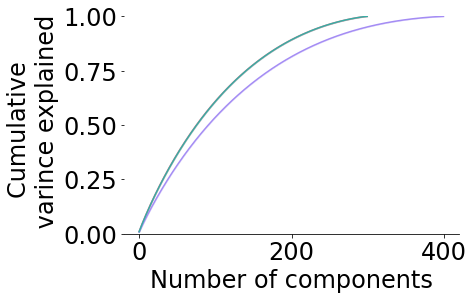

In [23]:
fig, ax = plt.subplots()
sns.lineplot(x="components", y="variance",
             hue="condition",
             data=full_pca_data[full_pca_data['condition']=='intact'], ax=ax, palette=cmap, hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.lineplot(x="components", y="variance",
             hue="condition",
             data=full_pca_data[full_pca_data['condition']=='rest'], ax=ax, palette=cmap, hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.lineplot(x="components", y="variance",
             hue="condition",
             data=full_pca_data[full_pca_data['condition']=='word'], ax=ax, palette=cmap, hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Cumulative varince explained')
ax.set_ylabel('Cumulative \n varince explained',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.set_ylim(0, 1)
ax.legend().set_visible(False)

In [11]:
full_data = pd.DataFrame()

rfun = 'PCA'
for l in levels:
    for cond in conditions:
        data = pd.read_csv(os.path.join(data_dir, f'{rfun}'+ f'_lev_{l}'+ f'_{cond}' + '.csv'))

        data = data.rename(columns={'Unnamed: 0': "Number of features"})
        melted_data = pd.melt(data, id_vars=['Number of features'], var_name='Subject', value_name='Percent variance')
        melted_data['Condition'] = cond
        melted_data['Level'] = l

        if full_data.empty:
            full_data = melted_data
        else:
            full_data = full_data.append(melted_data)


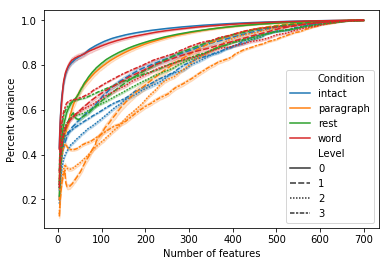

In [13]:
sns.lineplot(x='Number of features', y='Percent variance', hue='Condition', style="Level", data=full_data)  

In [14]:
parsed_data = full_data[full_data['Number of features'] < 100]

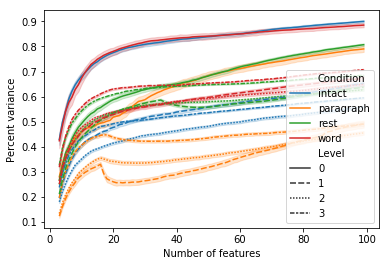

In [15]:
sns.lineplot(x='Number of features', y='Percent variance', hue='Condition', style="Level", data=parsed_data)  

In [16]:
parsed_data = full_data[full_data['Number of features'] < 60]

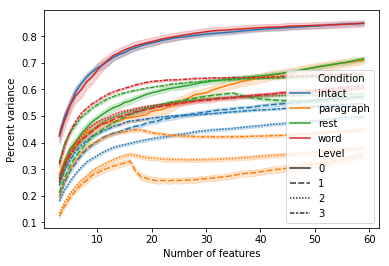

In [17]:
sns.lineplot(x='Number of features', y='Percent variance', hue='Condition', style="Level", data=parsed_data)  

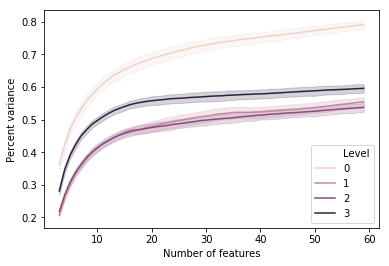

In [18]:
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data)  

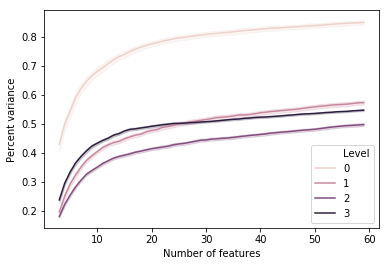

In [19]:
parsed_data_intact = parsed_data[parsed_data['Condition'] == 'intact']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_intact)  

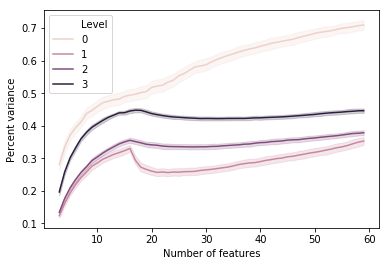

In [20]:
parsed_data_paragraph = parsed_data[parsed_data['Condition'] == 'paragraph']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_paragraph)  

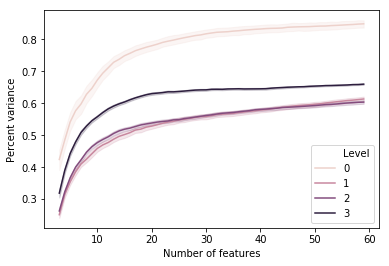

In [21]:
parsed_data_word = parsed_data[parsed_data['Condition'] == 'word']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_word)  

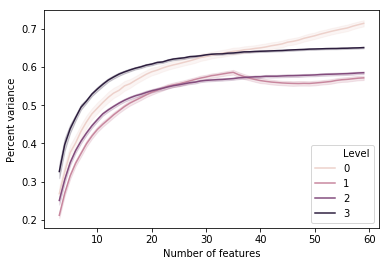

In [22]:
parsed_data_rest = parsed_data[parsed_data['Condition'] == 'rest']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_rest)  

In [23]:

full_data = pd.DataFrame()

rfun = 'eigenvector_centrality'
for l in levels:
    for cond in conditions:
        data = pd.read_csv(os.path.join(data_dir, f'{rfun}'+ f'_lev_{l}'+ f'_{cond}' + '.csv'))

        data = data.rename(columns={'Unnamed: 0': "Number of features"})
        melted_data = pd.melt(data, id_vars=['Number of features'], var_name='Subject', value_name='Percent variance')
        melted_data['Condition'] = cond
        melted_data['Level'] = l

        if full_data.empty:
            full_data = melted_data
        else:
            full_data = full_data.append(melted_data)


In [24]:
parsed_data = full_data[full_data['Number of features'] < 60]

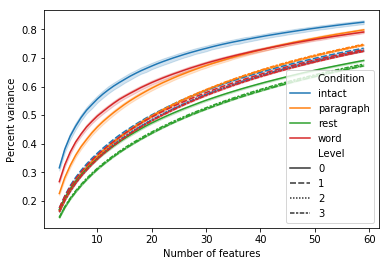

In [25]:
sns.lineplot(x='Number of features', y='Percent variance', hue='Condition', style="Level", data=parsed_data)  

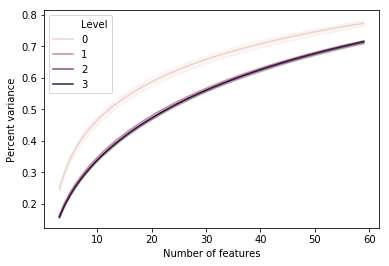

In [26]:
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data)  

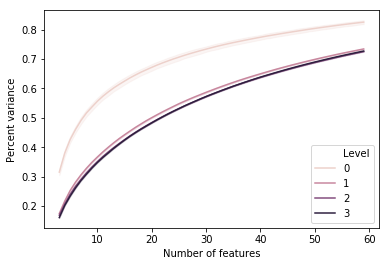

In [27]:
parsed_data_intact = parsed_data[parsed_data['Condition'] == 'intact']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_intact)  

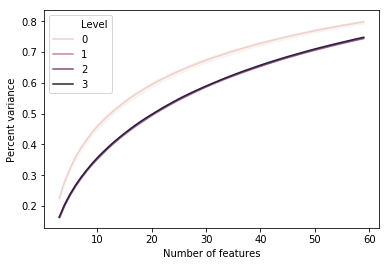

In [28]:
parsed_data_paragraph = parsed_data[parsed_data['Condition'] == 'paragraph']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_paragraph)  

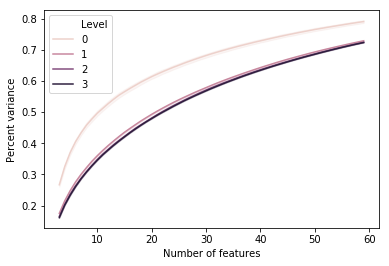

In [29]:
parsed_data_word = parsed_data[parsed_data['Condition'] == 'word']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_word)  

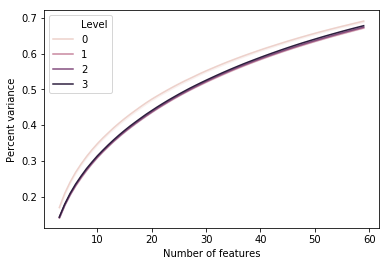

In [30]:
parsed_data_rest = parsed_data[parsed_data['Condition'] == 'rest']
sns.lineplot(x='Number of features', y='Percent variance', hue='Level', data=parsed_data_rest)  